In [1]:
import pandas as pd
import numpy as np
import helper
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.style as style
style.use('fivethirtyeight')

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

In [3]:
# importing data
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)
# data processing
train, test = helper.data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass','MoSold'],
                                             remove_PID = False
                                        )

# feature engineering wrapper
train, test = helper.feature_engineering_wrapper(train, test)

# importing school feature
schools = pd.read_csv('schoolFeatures.csv',index_col = 0)
school_keep = [
    'PID',
    'closestSchool'
]
schools = schools[school_keep]

# merge school feature onto original data set.
train = train.merge(schools, how = 'left', left_on = 'PID', right_on = 'PID')
test = test.merge(schools, how = 'left', left_on = 'PID', right_on = 'PID')

train = train.dropna(subset=['closestSchool'])
train = train.reset_index(drop=True)

test = test.dropna(subset=['closestSchool'])
test = test.reset_index(drop=True)

In [4]:
cat_feats = train.select_dtypes(['object','bool']).columns.to_list()
num_cols = train.select_dtypes(['float64','int64']).columns.to_list()
num_cols.remove('SalePrice')
num_cols.remove('PID')

clf, transformer, scaler, clf_old = helper.lasso_grid_cv(train, cat_feats,
                  starting_alphas_= [0.0001, 0.0003, 0.0006, 0.001, 
                                    0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                    0.3, 0.6, 1],
                  n_jobs_ = -1,
                  cv_ = 5
                                               )

Performing Grid Search with alphas of: [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]
Current best alpha: 0.001
Current best CV R2: 0.9473038743358806
Performing Grid Search with alphas of: [0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001  0.0011 0.0012
 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019]
Current best alpha: 0.0013000000000000002
Current best CV R2: 0.9473979196455631
Modeling complete :)


In [5]:
clf.best_score_

0.9473979196455631

In [6]:
X_tst = test.drop(['SalePrice','PID'],axis=1)
X_tst = transformer.transform(X_tst)
X_tst = scaler.transform(X_tst)
y_tst = np.log(test['SalePrice'])

clf.score(X_tst,y_tst)

0.9209546644661619

In [7]:
columns_transformed = transformer.named_transformers_['Cat'].get_feature_names(input_features= cat_feats)
new_columns = list(columns_transformed)+num_cols

coef_df = pd.DataFrame({'features':new_columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

,features,coefs,coefs_abs
0,GrLivArea_square_root,6.521832e-02,6.521832e-02
1,year_since_built_square_root,-6.364162e-02,6.364162e-02
2,total_sf_square_root,6.317802e-02,6.317802e-02
3,overall_score_square_root,5.160967e-02,5.160967e-02
4,LotArea_square_root,3.561651e-02,3.561651e-02
...,...,...,...
137,Neighborhood_Timber,2.647960e-05,2.647960e-05
138,Exterior2nd_PreCast,2.132539e-05,2.132539e-05
139,Condition1_RRNe,1.780155e-05,1.780155e-05
140,MoSold_8,-4.190908e-06,4.190908e-06


In [8]:
cv_old_df = pd.DataFrame({'alpha':clf_old.cv_results_['param_alpha'].data,
                     'mean_test_score':clf_old.cv_results_['mean_test_score'],
                      'split0_test_score':clf_old.cv_results_['split0_test_score'],
                      'split1_test_score':clf_old.cv_results_['split1_test_score'],
                      'split2_test_score':clf_old.cv_results_['split2_test_score'],
                      'split3_test_score':clf_old.cv_results_['split3_test_score'],
                      'split4_test_score':clf_old.cv_results_['split4_test_score'],

                     })
cv_old_df

,alpha,mean_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.0001,0.944043,0.934107,0.943180,0.953938,0.950387,0.938602
1,0.0003,0.945956,0.938868,0.943106,0.956865,0.950053,0.940886
2,0.0006,0.946724,0.941845,0.943086,0.957672,0.949869,0.941150
3,0.001,0.947304,0.943825,0.943219,0.957842,0.950312,0.941321
4,0.003,0.945760,0.945078,0.942948,0.954756,0.946754,0.939264
5,0.006,0.941662,0.944706,0.940088,0.948628,0.940097,0.934793
6,0.01,0.936370,0.942364,0.936137,0.941049,0.934137,0.928165
7,0.03,0.911632,0.923806,0.912060,0.915520,0.905819,0.900955
8,0.06,0.861864,0.879373,0.858497,0.863103,0.853345,0.855005
9,0.1,0.790364,0.811863,0.780752,0.789265,0.777702,0.792239


In [9]:
cv_df = pd.DataFrame({'alpha':clf.cv_results_['param_alpha'].data,
                     'mean_test_score':clf.cv_results_['mean_test_score'],
                      'split0_test_score':clf.cv_results_['split0_test_score'],
                      'split1_test_score':clf.cv_results_['split1_test_score'],
                      'split2_test_score':clf.cv_results_['split2_test_score'],
                      'split3_test_score':clf.cv_results_['split3_test_score'],
                      'split4_test_score':clf.cv_results_['split4_test_score'],

                     })
cv_df

,alpha,mean_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.0003,0.945956,0.938868,0.943106,0.956865,0.950053,0.940886
1,0.0004,0.946297,0.940398,0.943100,0.957056,0.949827,0.941104
2,0.0005,0.946513,0.941218,0.943081,0.957413,0.949671,0.941181
3,0.0006,0.946724,0.941845,0.943086,0.957672,0.949869,0.941150
4,0.0007,0.946873,0.942397,0.943018,0.957747,0.950141,0.941064
5,0.0008,0.947049,0.942951,0.943037,0.957805,0.950344,0.941110
6,0.0009,0.947201,0.943437,0.943140,0.957828,0.950382,0.941219
7,0.001,0.947304,0.943825,0.943219,0.957842,0.950312,0.941321
8,0.0011,0.947353,0.944020,0.943278,0.957852,0.950207,0.941405
9,0.0012,0.947397,0.944209,0.943357,0.957868,0.950112,0.941440


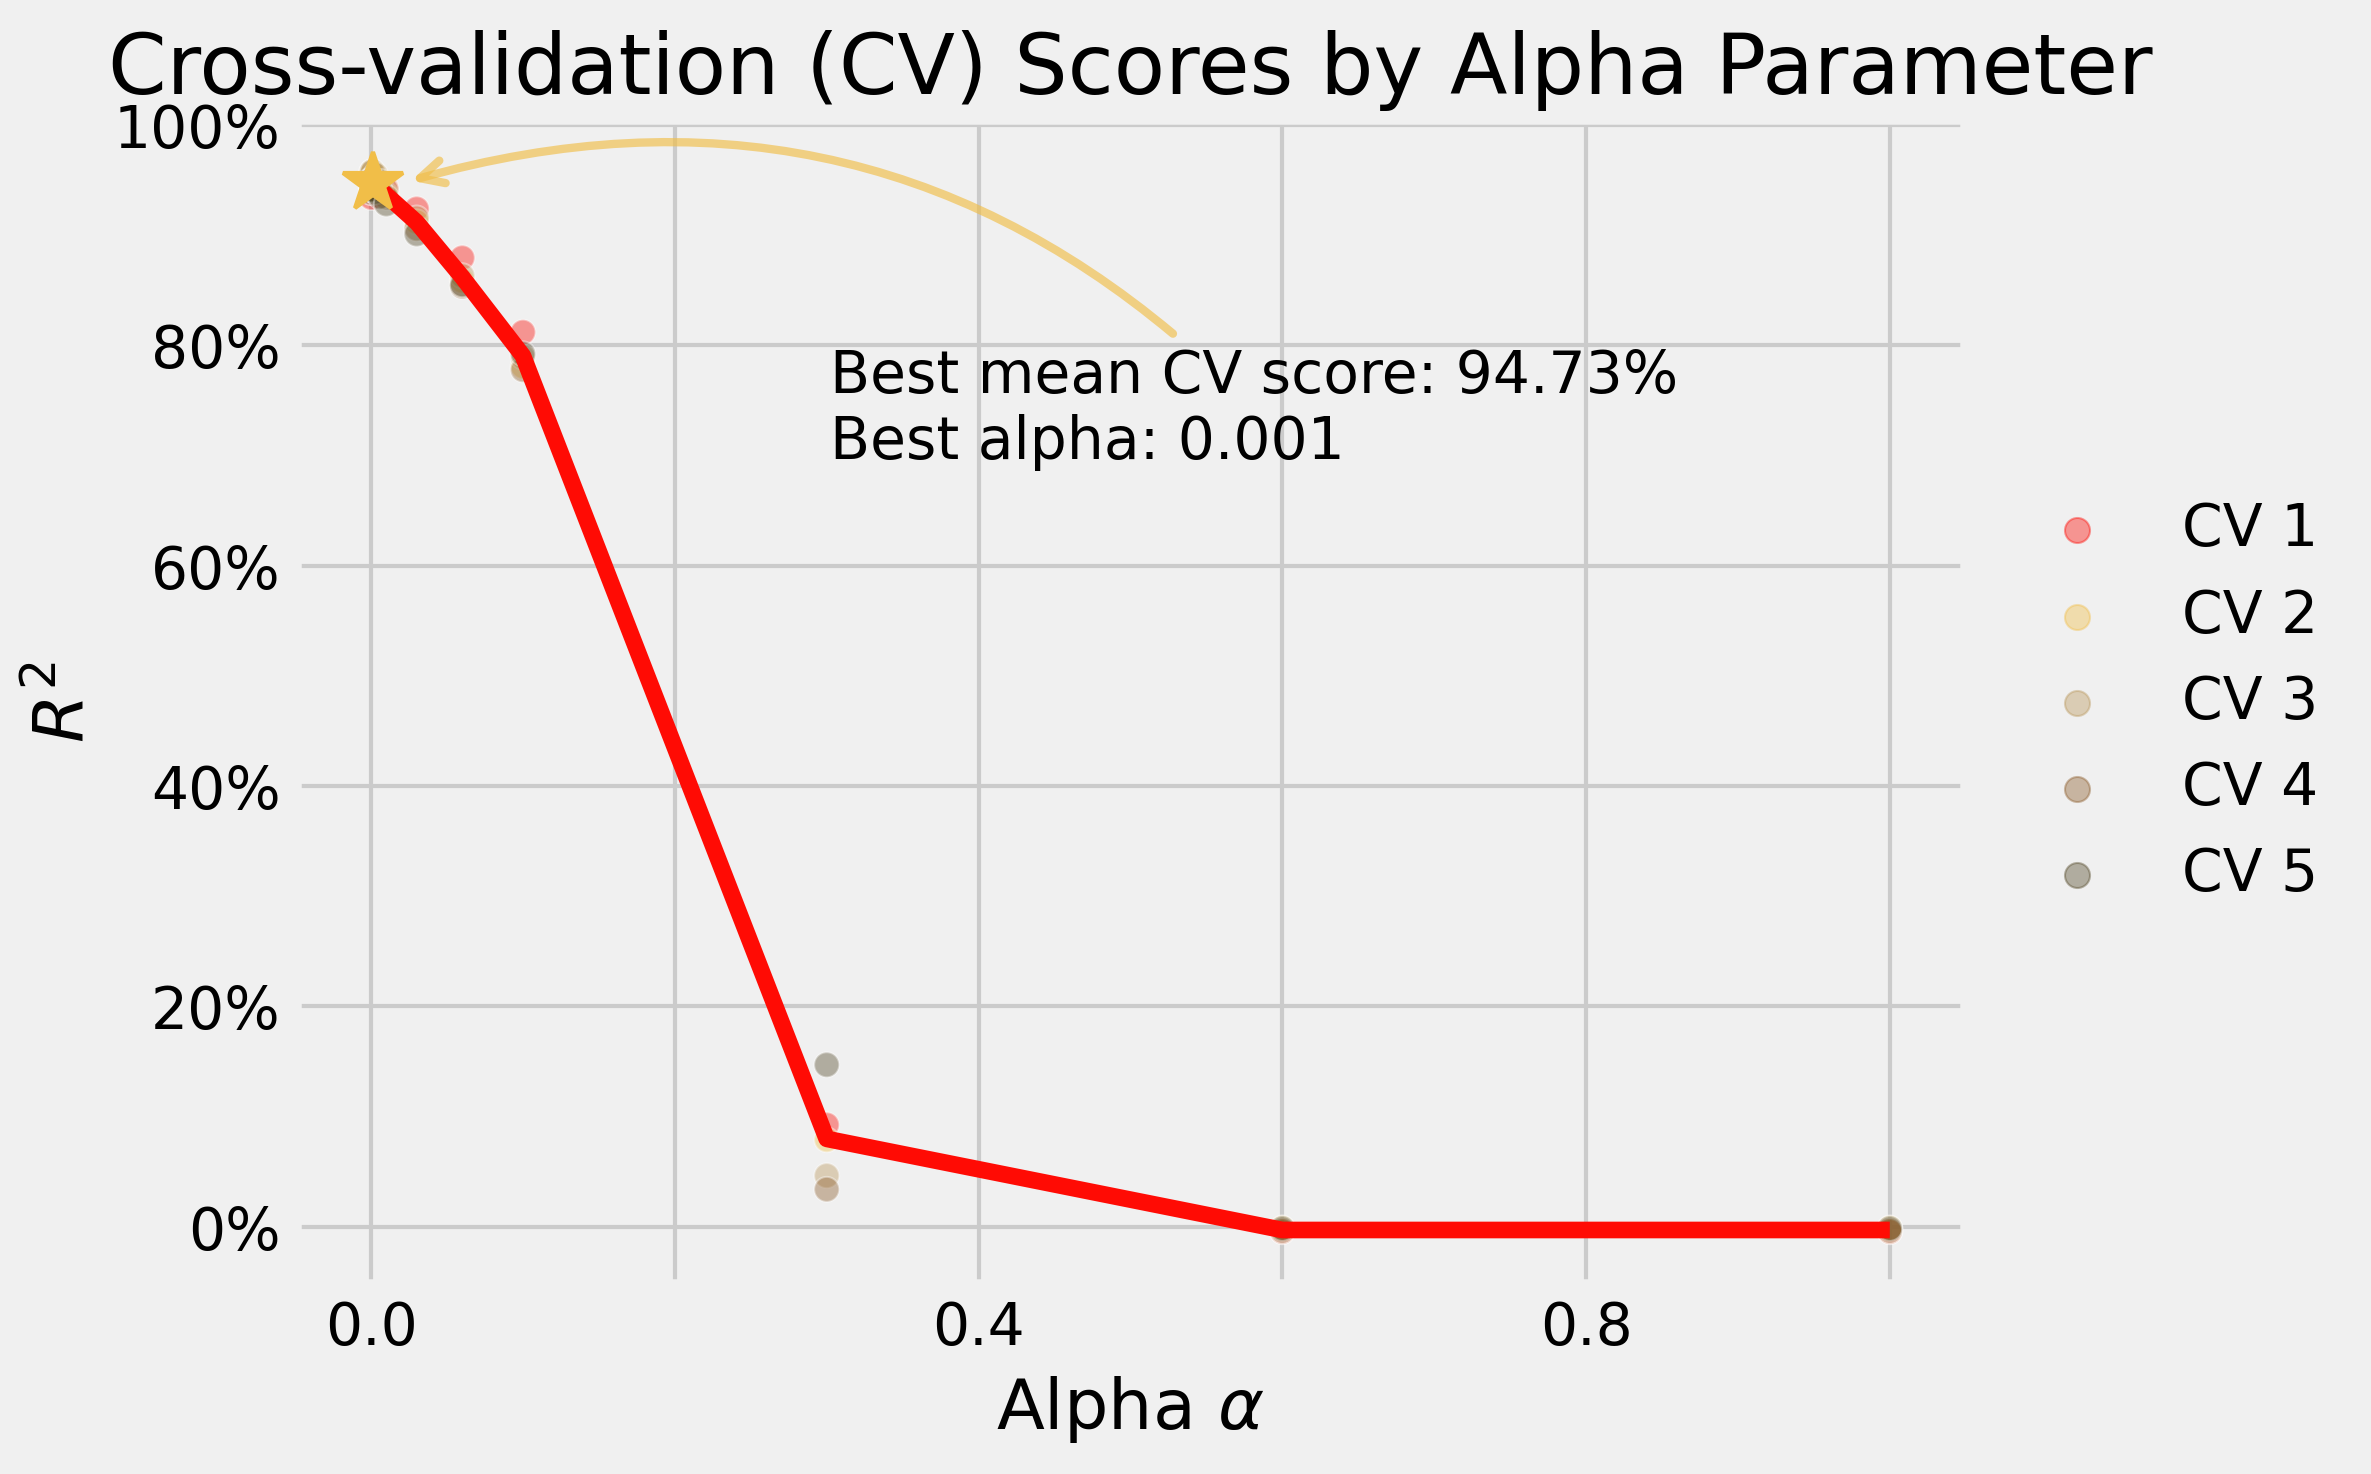

In [10]:
fig, ax = plt.subplots()
graph_df = cv_old_df
graph_df.columns = ['alpha', 'mean_test_score', 'CV 1', 'CV 2',
       'CV 3', 'CV 4', 'CV 5']
graph_df = pd.melt(graph_df,id_vars='alpha',value_vars=['CV 1', 'CV 2',
       'CV 3', 'CV 4', 'CV 5'],)
g_dot = sns.scatterplot(data = graph_df,x = 'alpha',y = 'value',ax=ax,hue='variable',alpha=.4,
                       )
g_line = sns.lineplot(data = cv_old_df,x = 'alpha',y = 'mean_test_score',ax=ax, 
                     )

sns.move_legend(g_line,loc='center left', bbox_to_anchor=(1, .5),frameon=False)
for lh in g_dot.legend_.legendHandles: 
    lh.set_alpha(.4)

best_alpha = clf_old.best_params_['alpha']
best_score = clf_old.best_score_

plt.plot(best_alpha,best_score,marker='*', markersize=15, color=colors[1])
plt.annotate(text="Best mean CV score: {:.2%}\nBest alpha: {:.2}".format(best_score,best_alpha), 
             xy=(best_alpha+.02, best_score), xycoords='data',
             xytext=(best_alpha+.3009,best_score-.25), textcoords='data',
             arrowprops=dict(arrowstyle="->",
                             color=colors[1],
                             lw=2,
                             alpha = .65,
                             connectionstyle="arc3,rad=0.3"),
            )

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
plt.title('Cross-validation (CV) Scores by Alpha Parameter')
plt.xlabel(r'Alpha $\alpha$')
plt.ylabel(r'$R^2$')
plt.show()

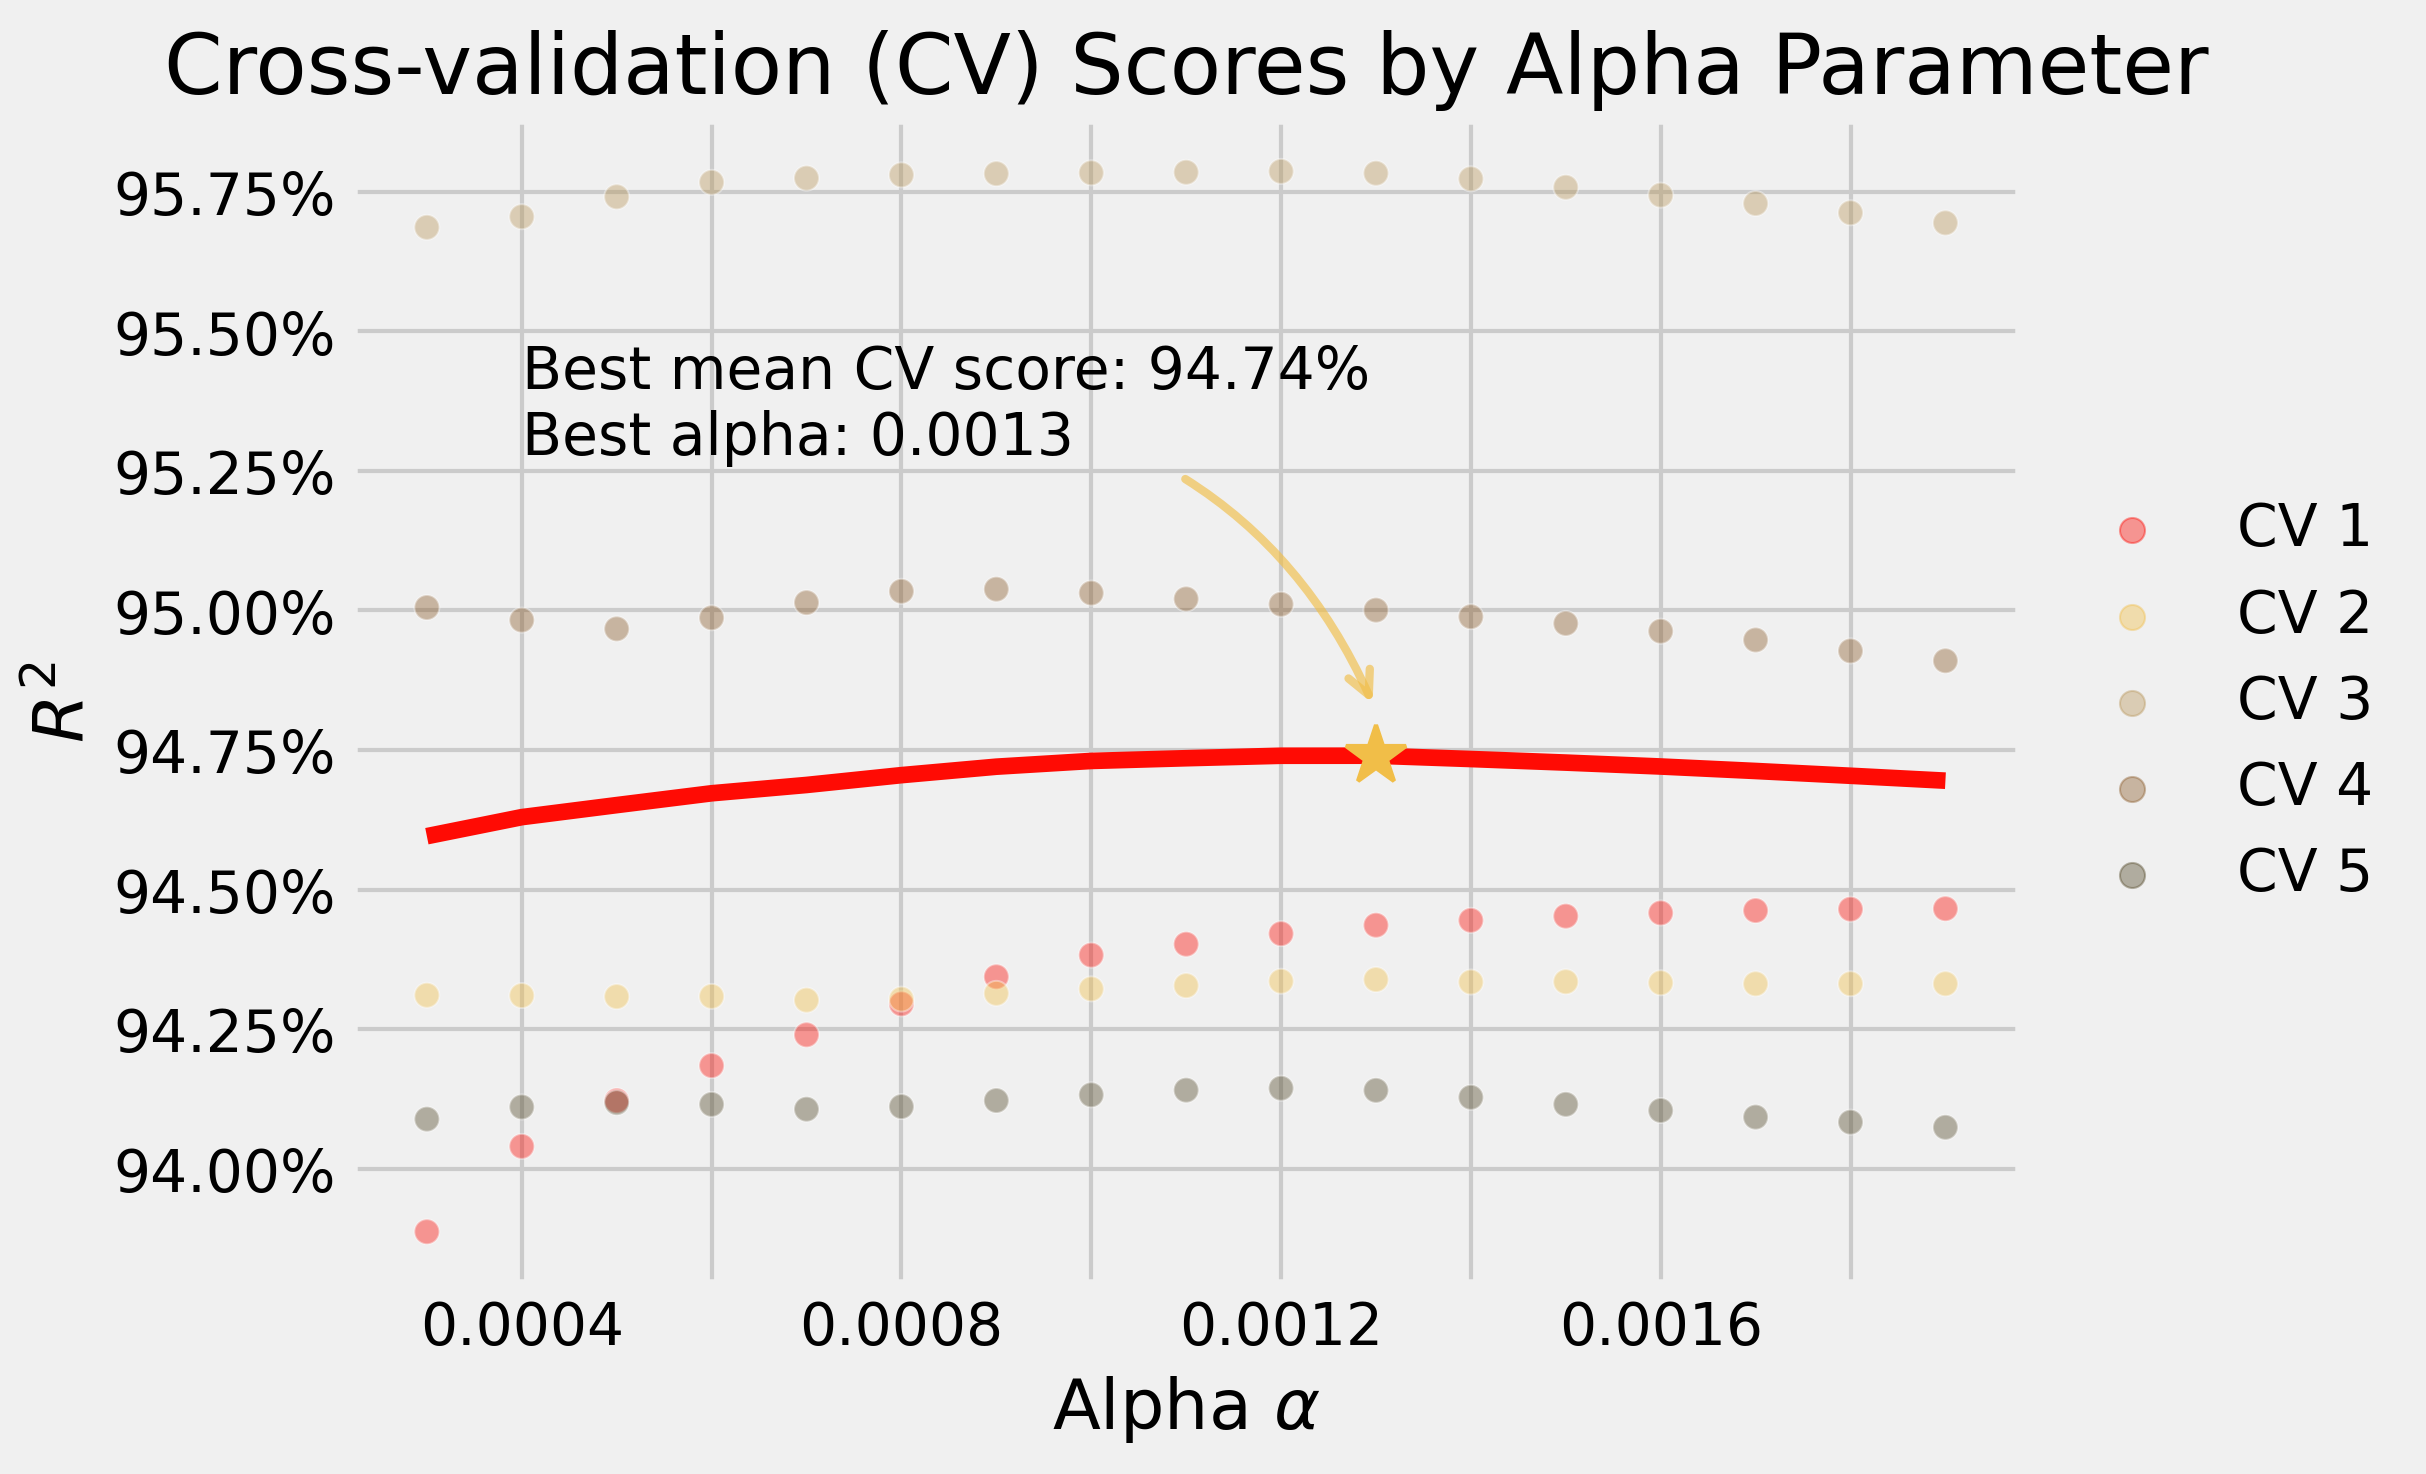

In [11]:
fig, ax = plt.subplots()
graph_df = cv_df
graph_df.columns = ['alpha', 'mean_test_score', 'CV 1', 'CV 2',
       'CV 3', 'CV 4', 'CV 5']
graph_df = pd.melt(graph_df,id_vars='alpha',value_vars=['CV 1', 'CV 2',
       'CV 3', 'CV 4', 'CV 5'],)
g_dot = sns.scatterplot(data = graph_df,x = 'alpha',y = 'value',ax=ax,hue='variable',alpha=.4,
                       )
g_line = sns.lineplot(data = cv_df,x = 'alpha',y = 'mean_test_score',ax=ax, 
                     )

sns.move_legend(g_line,loc='center left', bbox_to_anchor=(1, .5),frameon=False)
for lh in g_dot.legend_.legendHandles: 
    lh.set_alpha(.4)

best_alpha = clf.best_params_['alpha']
best_score = clf.best_score_

plt.plot(best_alpha,best_score,marker='*', markersize=15, color=colors[1])
plt.annotate(text="Best mean CV score: {:.2%}\nBest alpha: {:.2}".format(best_score,best_alpha), 
             xy=(best_alpha, best_score+.0008), xycoords='data',
             xytext=(best_alpha-.0009,best_score+.0054), textcoords='data',
             arrowprops=dict(arrowstyle="->",
                             color=colors[1],
                             lw=2,
                             alpha = .65,
                             connectionstyle="arc3,rad=-0.3"),
            )

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
plt.title('Cross-validation (CV) Scores by Alpha Parameter')
plt.xlabel(r'Alpha $\alpha$')
plt.ylabel(r'$R^2$')
plt.show()

Considering adding a num features graph of these same alphas.

In [12]:
# scaler = StandardScaler(with_mean=False)
# lasso = Lasso(max_iter = 50000, random_state = 33)

# X = train.drop(['SalePrice','PID'],axis=1)
# transformer = ColumnTransformer([("Cat", 
#                                   OneHotEncoder(handle_unknown = 'ignore'), 
#                                   cat_feats)], remainder='passthrough')
# X = transformer.fit_transform(X)
# X = scaler.fit_transform(X)
# y = np.log(train['SalePrice'])


# columns_transformed = transformer.named_transformers_['Cat'].get_feature_names(input_features= cat_feats)
# new_columns = list(columns_transformed)+num_cols

# num_feats = []
# for alpha in clf_old.cv_results_['param_alpha'].data:
#     print(alpha)
#     tuned_parameters = [{'alpha': [alpha]}]
#     clf_coef = GridSearchCV(lasso, tuned_parameters, cv=5)
#     clf_coef.fit(X, y)
#     coef_df = pd.DataFrame({'features':new_columns,'coefs':clf_coef.best_estimator_.coef_})
#     coef_df = coef_df[coef_df['coefs']!=0]
#     print(len(coef_df))
#     num_feats.append(len(coef_df))
    
# num_coef_df = pd.DataFrame({'alpha':clf_old.cv_results_['param_alpha'].data,
#                             'num_coefs':num_feats})
    